<a href="https://colab.research.google.com/github/c2010475075/DLProject2/blob/main/DL_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Project 2 - Deep RL using OpenAI Gym (CartPole) 💻
## Team members: Ling Yan Chan, Merve Gökce
Run this Jupyter Notebook on Visual Studio, Google Colab, or similar IDE.

Please always refers to the comments next to the codes, because sometimes errors occur when running the code snippets.

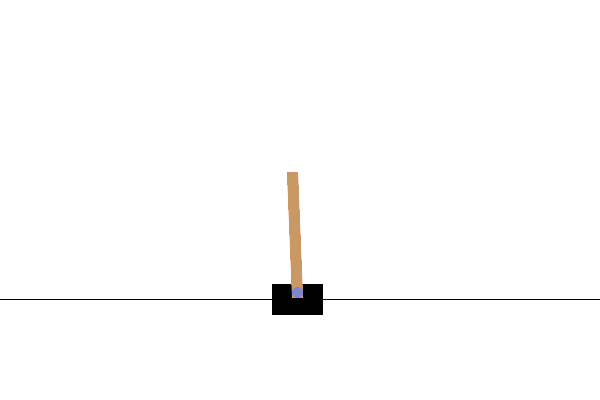

## Step 1: Install Dependencies

In [ ]:
!pip install tensorflow
!pip install gym
!pip install keras
!pip install keras-rl2
#!pip install dopamine-rl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.9 MB/s eta 0:00:00


## Step 2: Setting up Environment

In [ ]:
import gym
import random
import tqdm    # this is useful for progress bars
import numpy as np


In [ ]:
# Run this snippet again if deprecation message shown in the output

# Initialize the latest Gym environment (v0 is already outdated)
env = gym.make('CartPole-v1', render_mode='human')

# Get the number of states from the environment's observation space
states = env.observation_space.shape[0]

# Get the number of actions from the environment's action space
actions = env.action_space.n

# Get the reward
reward = env.reward_range.index

In [ ]:
states

4

In [ ]:
actions

2

In [ ]:
reward

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

In [ ]:
# Print out the action and observation space information
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")


Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In the Cartpole environment:


*  observation: is an array of 4 floats, describes the position and velocity of the cart
*  reward: is a scalar float value
*  action: is a scalar integer with only two possible values: 0 --> move left, 1 --> move right




### Experimental Setup

Purpose:

* To understand how the environment responds to random actions before building agent and train the model

* Helps establish a baseline performance for comparing the effectiveness of more sophisticated, trained agents against random decision-making

* Reset the environment, taking actions, and receiving feedback (rewards, next states) provides insights into how the environment operates

In [ ]:
# Initialize an empty list that intended to store total reward obtained in each episode
rewards_per_episode = []
# Initialize an empty list that intended to store average reward over the last 10 episodes
average_rewards = []

# Define the number of episodes we want to run
episodes = 10

# Loop over each episode
for episode in range(1, episodes + 1):
    # Run the 2nd cell from step 2 before running this cell, otherwise error occurs
    state = env.reset()  # Reset the environment at the start of each episode
    done = False
    total_reward = 0

    while not done:
        env.render()  # Render the environment to visualize the cartpole

        # Step the environment with the selected action
        n_state, reward, done, info = env.step(env.action_space.sample())

        # Accumulate the total reward
        total_reward += reward

    # After each episode
    rewards_per_episode.append(total_reward)
    average_rewards.append(np.mean(rewards_per_episode[-100:]))  # Average of last 100 episodes

    # Print the total score (reward) for the episode
    print(f'Episode:{episode} Total Reward: {total_reward}')
    print(f'Observation:{n_state} -> {reward}')

env.close()  # Close the environment


Episode:1 Total Reward: 17.0
Observation:[-0.14514895 -1.3425907   0.22398017  2.3474844 ] -> 1.0
Episode:2 Total Reward: 19.0
Observation:[ 0.06535491  0.9760874  -0.22968994 -1.7984033 ] -> 1.0
Episode:3 Total Reward: 13.0
Observation:[-0.20325236 -0.6285322   0.23371537  1.2139646 ] -> 1.0
Episode:4 Total Reward: 18.0
Observation:[ 0.08993372  1.1723477  -0.23853168 -2.238609  ] -> 1.0
Episode:5 Total Reward: 31.0
Observation:[-0.08560414 -0.9624326   0.22687633  1.7563305 ] -> 1.0
Episode:6 Total Reward: 27.0
Observation:[ 0.01850211 -0.546639   -0.21714905 -0.29328135] -> 1.0
Episode:7 Total Reward: 35.0
Observation:[ 0.02206616 -0.5684872   0.23163332  1.5298901 ] -> 1.0
Episode:8 Total Reward: 15.0
Observation:[ 0.1347872   0.95884335 -0.22604194 -1.8235765 ] -> 1.0
Episode:9 Total Reward: 9.0
Observation:[ 0.15000188  0.6206769  -0.22199231 -1.14773   ] -> 1.0
Episode:10 Total Reward: 27.0
Observation:[ 0.13485359  1.0150441  -0.24254951 -1.649912  ] -> 1.0


From the above output, we can notice that the observations contain 4 sets of numbers, including position of cart, velocity of cat, angle of pole and rotation rate of pole respectively.

"reward": the reward we receive at each step. We are rewarded 1 point for each step in CartPole.

Our final goal is to maximize the total reward.

---



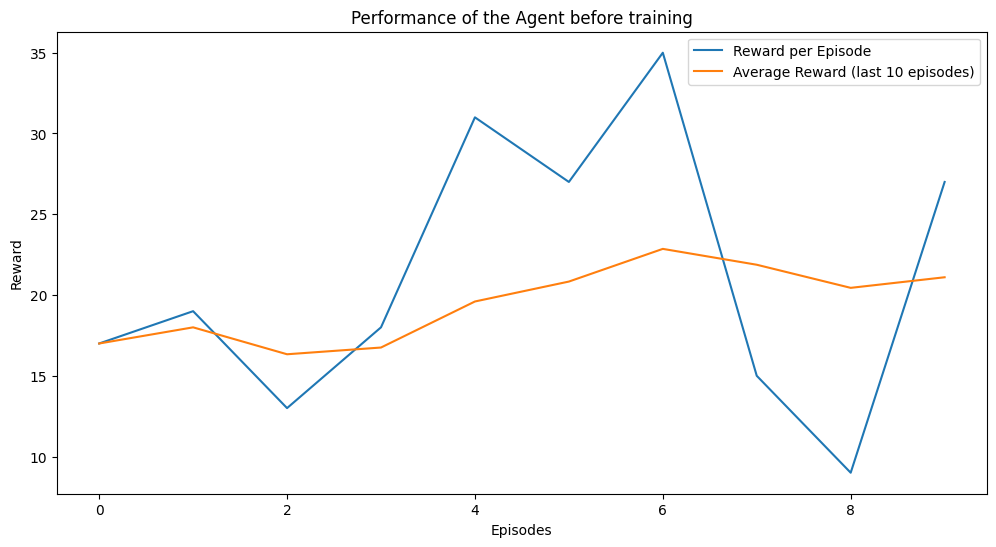

In [ ]:
import matplotlib.pyplot as plt

# plot the graph to show rewards_per_episode and average_rewards

plt.figure(figsize=(12, 6))
plt.plot(rewards_per_episode, label='Reward per Episode')
plt.plot(average_rewards, label='Average Reward (last 10 episodes)')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Performance of the Agent before training')
plt.legend()
plt.show()


In the above plotted graph, it shows 2 metrics: the reward per episode and the average reward over the last 10 episodes.

We can observe the following:
* Reward per Episode (Blue Line)🔵: This shows significant fluctuations in the reward from one episode to the next. This is expected for an untrained agent as it is taking random actions without any learned strategy.

* Average Reward (Orange Line)🟠: The average reward line is smoother than the reward per episode line, as it averages out the rewards over the last 10 episodes. It doesn't show a clear upward/downward trend, which aligns with the agent acting randomly before any training has occurred.

⚠ Please note that the variability of the graph is typical and expected in RL tasks, especially when the agent's policy isn't yet learned/optimized and is instead exploring the action space randomly.

## Step 3: Define the DL Model Building Function and Summarizing the Model

In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam

def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, states)))

    # Layer 1
    model.add(Dense(32, activation='relu'))

    # Layer 2
    model.add(Dense(16, activation='relu'))

    # Output Layer
    model.add(Dense(actions, activation='linear'))

    return model


In [ ]:
model = build_model(states, actions)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 4)                 0         
                                                                 
 dense_12 (Dense)            (None, 32)                160       
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 2)                 34        
                                                                 
Total params: 722 (2.82 KB)
Trainable params: 722 (2.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


⭐Please note that the below code "del model" should only run if error occurs in Step 4 (dqn.compile()).

"**Sequential**": The type of model used, which allows the addition of layers in a sequential order.

"**Dense**", "**Flatten**": Types of layers used in the model.

"**Adam**": The optimizer function for the model.

"**Flatten(input_shape=(1, states))**": Adds a Flatten layer to the model that will flatten the input. The input shape is specified as (1, states), meaning that the input will be a 1D array of length states.

"**Dense(32, activation='relu')**": Adds a fully connected (Dense) layer with 32 neurons and ReLU (rectified linear unit) activation. This is the first hidden layer. 32 neurons provide a balance between model complexity and computational efficiency. It's enough to learn significant patterns in the data without being overly complex.

"**Dense(16, activation='relu')**": Adds another Dense layer with 16 neurons and ReLU activation. This is the second hidden layer, with fewer neurons helps in further refining the features extracted by the first layer. Prevent overfitting by reducing the model's capacity slightly, forcing it to focus on the most important features.

"**Dense(actions, activation='linear')**": Adds the output layer with a number of neurons equal to actions and uses a linear activation function. This function is used for a regression-like output, suitable for Q-value predictions in RL.


The function returns the constructed model which can be used to predict the action values (Q-values) for each action given the current state of the environment.


---



In [ ]:
del model # this should only run if error occurs in step 4.

## Step 4: Setting Agent with Keras RL
We'll import the Keras RL Dependencies, do the setup, after that we are going to train it.

### Import Keras RL Dependencies
- We are using Deep Q-Networks (DQN), this is a variant of Q-learning and a value-based RL agent that trains a critic to estimate discounted expected cumulative long-term reward, which is suitable for our environment.

- Then we used BoltzmannQPolicy for action selection. This approach involves choosing an action with weighted probabilities.

- SequentialMemory for storing the various states, actions, and rewards.

In [ ]:
from keras import __version__
tensorflow.keras.__version__ = __version__ # ensure version consistency

# if error "cannot import name '__version__' from 'tensorflow.keras'" occur, change the callback.py line 8 from tensorflow.keras to keras import __version__
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

### Build the Agent

The algorithm used to solve an RL problem is represented by an AGENT. The DQN Agent can be used in any environment which has a discrete action space

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=10,
                   target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
# if error 'Sequential' object has no attribute '_compile_time_distribution_strategy' appears, then try to run the "del model" function in previous cell, after that run Step 3 again.
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

In [ ]:
from tensorflow.keras.callbacks import Callback

class EpisodeRewardCallback(Callback):
    def __init__(self):
        self.rewards_per_episode = []

    def on_episode_end(self, episode, logs={}):
        self.rewards_per_episode.append(logs['episode_reward'])

In [ ]:
# if depreciation message shown in the output, please stop running and re-run this cell again
reward_callback = EpisodeRewardCallback()
# if pygame.exit() error exists, please run the code "env = gym.make('CartPole-v1', render_mode='human')" in the step 2.
dqn.fit(env, nb_steps=50000, verbose=1, callbacks=[reward_callback])

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 205s 20ms/step - reward: 1.0000
102 episodes - episode_reward: 96.696 [8.000, 470.000] - loss: 2.019 - mae: 19.508 - mean_q: 39.548

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 203s 20ms/step - reward: 1.0000
48 episodes - episode_reward: 208.458 [147.000, 355.000] - loss: 3.084 - mae: 39.784 - mean_q: 80.490

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 209s 21ms/step - reward: 1.0000
48 episodes - episode_reward: 209.646 [153.000, 295.000] - loss: 2.277 - mae: 42.205 - mean_q: 85.206

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 208s 21ms/step - reward: 1.0000
36 episodes - episode_reward: 274.444 [159.000, 500.000] - loss: 1.661 - mae: 41.766 - mean_q: 84.164

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 203s 20ms/step - reward: 1.

### Interval Details:

* Episode Reward: Average reward received per episode within the interval, also shows the range of rewards (minimum and maximum)

* Loss: indicates how well the DQN is predicting the Q-values. Lower loss generally means better predictions

* MAE (Mean Absolute Error): Measures the average magnitude of errors in the predictions

* Mean Q: The average of the predicted Q-values. A higher value can indicate better learning of the Q-values over time

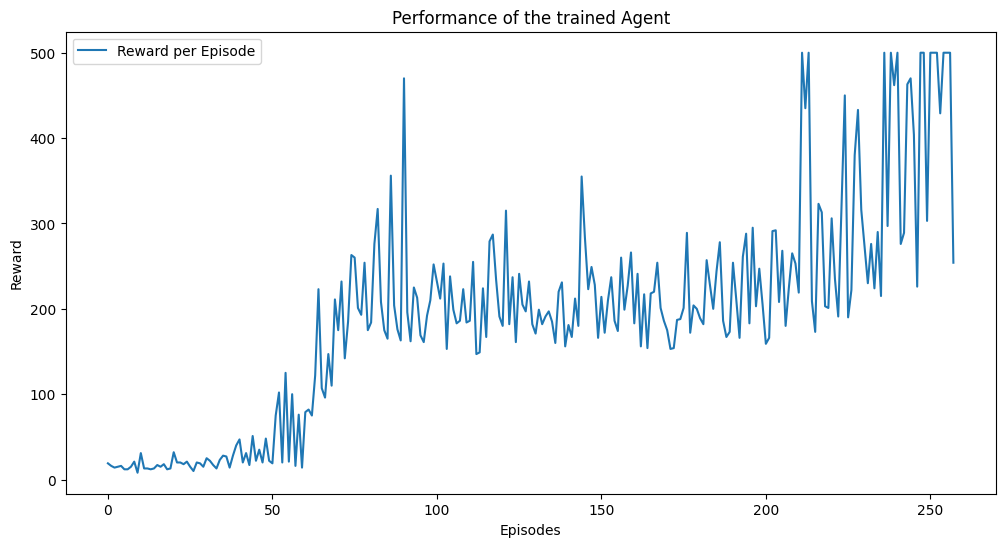

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # for calculations

# After the training
plt.figure(figsize=(12, 6))
plt.plot(reward_callback.rewards_per_episode, label='Reward per Episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Performance of the trained Agent')
plt.legend()
plt.show()

The plotted graph above shows the rewards per episode over the course of training episodes for the agent. Note: Maximum Rewards would be 500.

* Learning Progress: There is a clear upward trend📈 in the rewards per episode, especially noticeable in the initial episodes. This means that the agent is learning and improving its policy over time.

* Variability in Performance: After an initial period of learning and improvement, the performance of the agent exhibits high variability, with rewards per episode spiking up to the maximum and then dropping down again. This could indicate that while the agent has learned a policy that can occasionally achieve the maximum reward, it has not yet learned to consistently apply the optimal policy.

* Possible Convergence: The graph does not show a clear sign of convergence to a stable solution. Ideally, after sufficient training, the rewards would plateau, indicating that the agent has found a stable policy. The continued variability suggests that the agent may still be exploring the environment or that the environment itself has a high degree of stochasticity.

In [ ]:
# Run this snippet again if deprecation message shown in the output
# if pygame.exit() error exists, please run the code "env = gym.make('CartPole-v1', render_mode='human')" in the step 2.
scores = dqn.test(env, nb_episodes=10)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 500.000, steps: 500
Episode 2: reward: 500.000, steps: 500
Episode 3: reward: 500.000, steps: 500
Episode 4: reward: 500.000, steps: 500
Episode 5: reward: 500.000, steps: 500
Episode 6: reward: 500.000, steps: 500
Episode 7: reward: 500.000, steps: 500
Episode 8: reward: 500.000, steps: 500
Episode 9: reward: 500.000, steps: 500
Episode 10: reward: 500.000, steps: 500
500.0


## Step 5: Reload the Agent from memory

After training our model, we need to save the weights. We're going to save the trained weights of our DQNAgent to the file named 'dqn_weights.h5f'.

In [ ]:
# Save the model weights
dqn.save_weights('dqn_weights.h5f', overwrite=True)

When we want to reload the agent, we need to have the same model architecture and compile it before we can load the weights into it.

First step is to delete our model, environment and DQNAgent. Then, we should rebuild it using all the functions that we had and reload those weights to test it out.

In [ ]:
del model
del env
del dqn

In [ ]:
env = gym.make("CartPole-v1")

actions = env.action_space.n

states = env.observation_space.shape[0]

# Rebuild the model architecture
model = build_model(states, actions)

# Reinstantiate the agent with the same configuration as before
dqn = build_agent(model, actions)

dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

In [ ]:
# load our weights to test
dqn.load_weights('dqn_weights.h5f')

In [ ]:
dqn.test(env, nb_episodes=5)

After this step, we can see the output here, we're getting a much better result before we reload the agent from the memory. All the episodes have the reward of 500 points.


---



# Documentation
## Introduction
In this project, we'll implement the Deep Reinforcement Learning (Deep RL) using OpenAI Gym environment, with the DL model TensorFlow Keras API and train model using Keras-RL Agents.

Enviroment we chose: https://gymnasium.farama.org/environments/classic_control/cart_pole/

The Agent class we used: https://keras-rl.readthedocs.io/en/latest/agents/dqn/

The idea behind CartPole is, basically move the cart down the bottom in order to balance the pole above the cart. For each step it takes, we'll get a point with a maximum of 500 points. (FYI: The threshold for rewards is 500 for v1, while 200 for v0, but v0 is already outdated.)

Ideally we can see here, when we start off with our random steps, we're not going to get anywhere near 500, but once we use the DL and RL, we should be able to get a much closer to actually hitting our final result.

---


### There are some crucial concept we'll need to know in this project.
▶Action Space: defines the set of actions that an agent can take. This is typically discrete and small. In CartPole, We got 2 movements, either **Left** or **Right**. That means by creating the environment, we have 2 actions available.

In Step 2, "env.action_space.n" will give us the number of distinct actions. For CartPole, this number is 2.


▶Observation Space: defines the format and range of observations that the agent receives from the environment. In CartPole, the observation is a set of continuous values representing the physics of the system, such as the angle of the pole and the position of the cart. This can be either **discrete** or **continuous**. In this case, CartPole is continuous.

In Step 2, "env.observation_space.shape[0]" will give us the size of the observation space. For CartPole, this might include parameters like the **position of the cart**, the **velocity of the cart**, the **angle of the pole**, and the **rotation rate of the pole**.

▶Rewards: A reward of +1 for every step taken, including the termination step. Threshold is 500. You can see that before training, the reward is poor with the maximum 80 scores according to our last output.



---

## Performance - Comparison

### Interval Analysis:

* Interval 1: The agent completed 102 episodes with an average reward of 96.696. The rewards ranged from 8.000 to 470.000. The loss was 2.019, mean absolute error (MAE) was 19.508, and the mean Q-value was 39.548

* Interval 2: Completed 48 episodes with an average reward of 208.458, indicating significant improvement. Loss increased to 3.084, MAE was 39.784, and mean Q-value rose to 80.490.

* Interval 3: Similar to Interval 2, with 48 episodes and an average reward of 209.646. Loss decreased to 2.277, MAE increased to 42.205, and mean Q-value was 85.206.

* Interval 4: Showed further improvement with 36 episodes and a higher average reward of 274.444. Loss decreased to 1.661, MAE slightly decreased to 41.766, and mean Q-value was 84.164.

* Interval 5: Training completed successfully

### Key Observations:

* Learning Improvement: There's a clear upward trend in the average reward per episode, suggesting that the agent is learning and adapting its strategy to balance the pole for longer periods.

* Loss and MAE Trends: The loss and MAE values fluctuate across intervals. Ideally, a decreasing trend in loss is desired, indicating better prediction of Q-values. The increase in loss in Interval 2 followed by a decrease suggests the agent is still refining its strategy.

* Mean Q-Value: This value increases across intervals, which generally indicates that the agent is getting better at estimating the value of its actions.

### Conclusion drawn:

* The agent shows progressive improvement in handling the CartPole environment, as evidenced by the increasing episode rewards.

* The fluctuations in loss and MAE suggest ongoing learning and adaptation.

* Overall, the training session seems successful in enhancing the agent's performance over time.


---


## Pre-training Performance:

Analyzing the plotted graph - "Performance of the Agent before training":

* The rewards per episode vary significantly from one episode to another, which is a typical indicator of an agent acting on a random policy without any learning involved.

* The average reward per episode appears relatively low, fluctuating around a mean that doesn't show any improvement trend. This indicates the agent's lack of understanding of the task at hand.

* The average reward line, which is relatively flat, suggests that there's little to no learning or strategy development happening during these episodes.

## Post-training Performance:

Analyzing the plotted graph - "Performance of the trained Agent":

* There's a clear upward trend in the reward per episode, indicating that the agent is learning and improving its strategy for balancing the pole in the CartPole environment.

* The rewards become more consistent and reach higher values, with many episodes achieving the maximum reward, which often signifies the agent has learned to balance the pole for a more extended period or even until the environment's maximum time limit.

* Unlike the pre-training performance, the post-training graph shows the agent achieving and maintaining a high reward level, suggesting that the agent's actions are now informed by a learned policy rather than random choices.

### Key Metrics for comparison:

* Average Reward: The average reward after training is significantly higher than before training. This increase in average reward is a direct indicator of the agent's improved performance.

* Consistency of Performance: The post-training rewards show less variability in comparison to the pre-training phase, signifying that the agent's behavior is more consistent and reliable after learning.

* Maximum & Minimum Rewards: Before training, the rewards are generally low with a narrow range between the minimum and maximum rewards. After training, the range widens, and the maximum rewards increase substantially, reflecting the agent's ability to succeed in the environment more frequently.
